# THYAO HİSSE SENEDİ

Bu çalışmada **THYAO** hisse senedinin "2021-01-01", "2024-01-01" tarihleri arasındaki kapanış fiyatlarının farklı makine öğrenimi modelleriyle tahminleri yapılacak, bu tahminler üzerinden iyileştirmeler yapılarak analiz yapılacaktır.

In [54]:
# Veri okuma ve işleme adımında kullanılacak kütüphaneler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# !pip install tensorflow
import tensorflow as tf

# Model için kullanılacak kütüphaneler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model değerlendirme ve veri ölçeklendirmede kullanılacak kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Uyarıları kapatmak için kullanılacak kütüphaneler
import itertools
import warnings
warnings.filterwarnings('ignore')
import os

In [55]:
#import yfinance as yf
#df = yf.download("THYAO.IS", start="2021-01-01", end="2024-01-01");

In [56]:
df = pd.read_csv("THYAO.IS.csv")

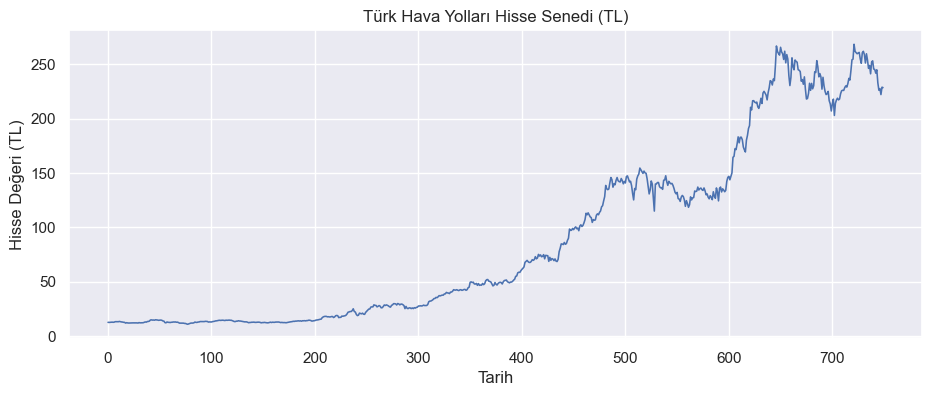

In [57]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = df["Close"].plot(linestyle='-', linewidth=1.15, label='Daily')
ax.set_ylabel("Hisse Değeri (TL)")
ax.set_xlabel("Tarih")
ax.set_title("Türk Hava Yolları Hisse Senedi (TL)")
plt.show();

In [58]:
# Eğitim-Doğrulama-Test seti olarak bölelim:   85-7.5-7.5
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)

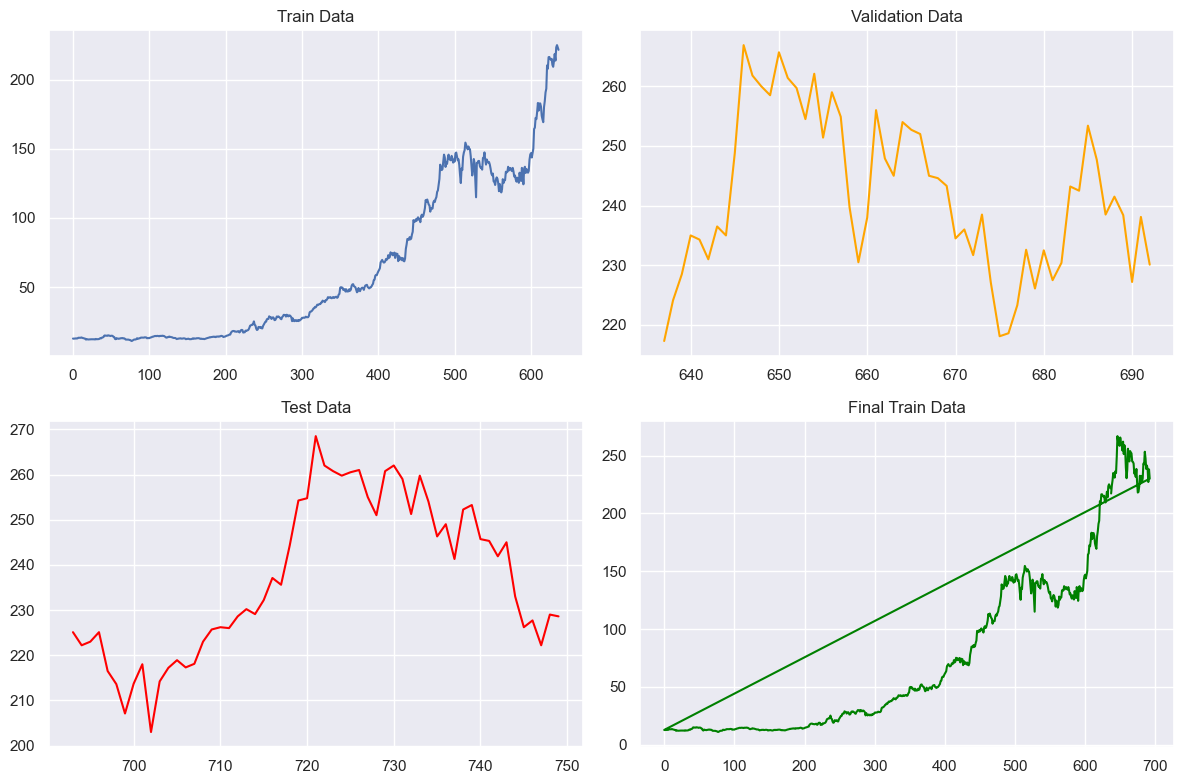

In [59]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
train.plot(ax=axes[0, 0], title="Train Data")
validation.plot(ax=axes[0, 1], title="Validation Data",color="orange")
test.plot(ax=axes[1, 0], title="Test Data",color="red")
final_train.plot(ax=axes[1, 1], title="Final Train Data",color="green")
plt.tight_layout()
plt.show();

# SES MODEL

## SES MODEL PARAMETRE OPTİMİZASYONU

In [60]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
def ses_optimizer(train, alphas, step=len(validation)):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        validation_pred = ses_model.forecast(step)
        mae = mean_absolute_error(validation, validation_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae
alphas = np.arange(0.01, 1, 0.01)
best_alpha, best_mae = ses_optimizer(train, alphas, step=len(validation));

best_alpha: 0.6 best_mae: 19.6797


### ONE STEP AHEAD METHOD(SES)

In [61]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
thyao_ses_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = SimpleExpSmoothing(final_train).fit(smoothing_level=best_alpha)
    # model_fit = model.fit()           # final_train ile oluşturulan model best_alpha ile eğitildi.
    output = model_fit.forecast()
    yhat = output[0]
    thyao_ses_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value);

### SES MODEL HATASI

In [62]:
thyao_ses_rmse = np.sqrt(mean_squared_error(test,thyao_ses_model_predictions)) # RMSE =  5.9855888302205456
test = np.array(test)
thyao_ses_model_predictions = np.array(thyao_ses_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
thyao_ses_mape = mape(test,thyao_ses_model_predictions) 
print(thyao_ses_mape) # MAPE = 1.99924582363152

1.999245822970909


### SES MODELİNİN TAHMİN GRAFİĞİ:

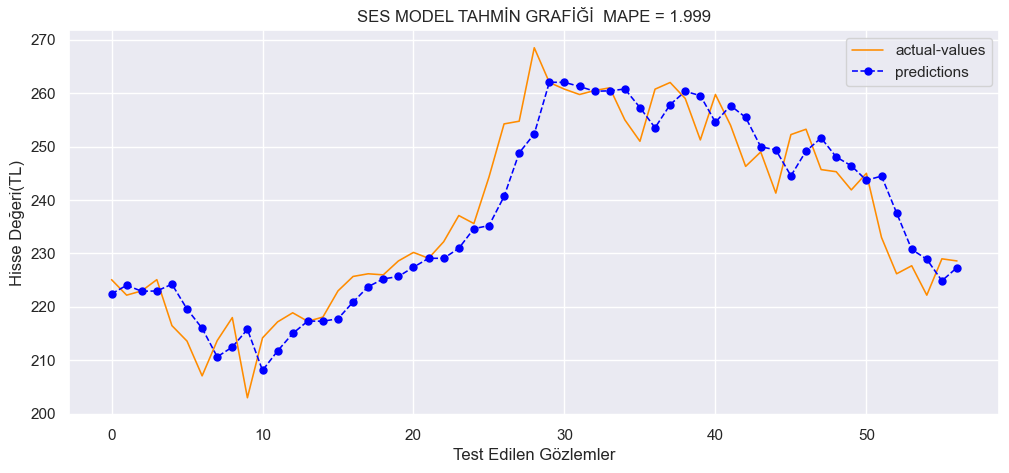

In [63]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(thyao_ses_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Test Edilen Gözlemler")
plt.ylabel("Hisse Değeri(TL)")
plt.title("SES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(thyao_ses_mape,3)))
plt.legend();

SES MODEL tahminleri mavi, gerçek değerler sarı renkli belirtilmiştir. Modelin yüzdelik hata oranı 1.99'dur.  

# DES MODEL
## DES MODEL PARAMETRE OPTİMİZASYONU

In [64]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
def des_optimizer(train, alphas, betas, step=len(validation)):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            validation_pred = des_model.forecast(step)
            mae = mean_absolute_error(validation, validation_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae
alphas = np.arange(0.01, 1, 0.01)
betas = np.arange(0.1, 1, 0.01)
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=len(validation))
# best_alpha: 0.02 best_beta: 0.99 best_mae: 11.0609

best_alpha: 0.02 best_beta: 0.99 best_mae: 11.0609


### ONE STEP AHEAD METHOD(DES)

In [65]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
thyao_des_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = ExponentialSmoothing(final_train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
    output = model_fit.forecast()
    yhat = output[0]
    thyao_des_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### DES MODEL HATASI

In [66]:
thyao_des_rmse = np.sqrt(mean_squared_error(test,thyao_des_model_predictions)) 
test = np.array(test)
thyao_des_model_predictions = np.array(thyao_des_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
thyao_des_mape = mape(test,thyao_des_model_predictions) 
print(thyao_des_mape) # MAPE = 12.393517122415423

12.393517122415423


### DES MODEL TAHMİN GRAFİĞİ:

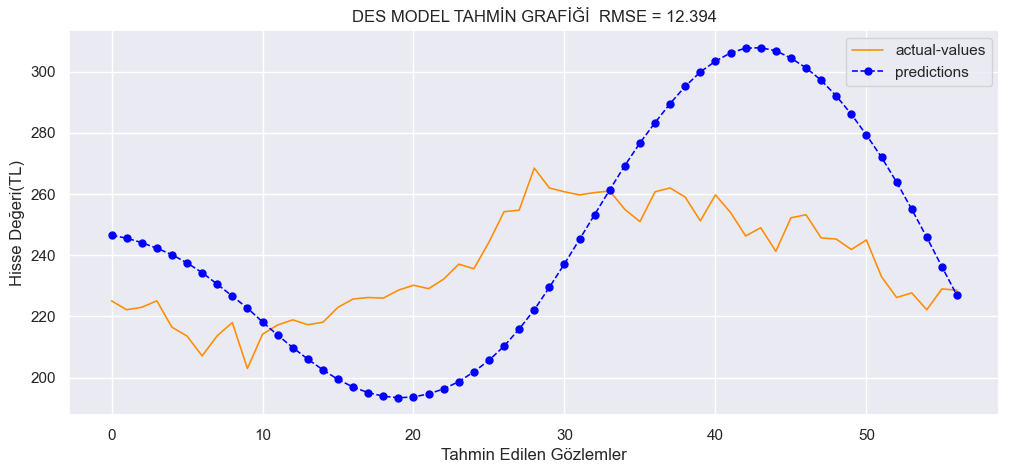

In [67]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(thyao_des_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tahmin Edilen Gözlemler")
plt.ylabel("Hisse Değeri(TL)")
plt.title("DES MODEL TAHMİN GRAFİĞİ  "+ "RMSE = " + str(round(thyao_des_mape,3)))
plt.legend();

# TES MODEL
## TES MODEL PARAMETRE OPTİMİZASYONU

In [68]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)

def tes_optimizer(train, abg, step=len(validation)):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        validation_pred = tes_model.forecast(step)
        mae = mean_absolute_error(validation, validation_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae
alphas = betas = gammas = np.arange(0.01, 1, 0.1)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=len(validation))
# best_alpha: 0.11 best_beta: 0.51 best_gamma: 0.01 best_mae: 12.9814

best_alpha: 0.11 best_beta: 0.51 best_gamma: 0.01 best_mae: 12.9814


### 1 STEP AHEAD METHOD (TES)

In [69]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)

thyao_tes_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = ExponentialSmoothing(final_train, trend="add", seasonal="add", seasonal_periods=5).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
    # model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    thyao_tes_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value);

### TES MODEL HATASI

In [70]:
thyao_tes_rmse = np.sqrt(mean_squared_error(test,thyao_tes_model_predictions)) 
test = np.array(test)
thyao_tes_model_predictions = np.array(thyao_tes_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
thyao_tes_mape = mape(test,thyao_tes_model_predictions) 
print(thyao_tes_mape)# MAPE = 3.273442305090358

3.2734499178998315


### TES MODEL TAHMİN GRAFİĞİ:

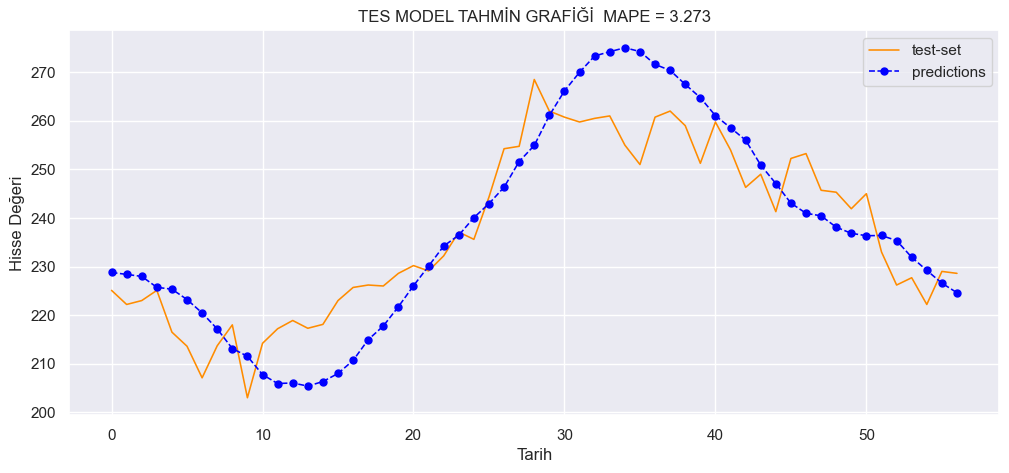

In [71]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(thyao_tes_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("TES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(thyao_tes_mape,3)))
plt.legend();

# ARIMA MODEL
## ARIMA MODEL PARAMETRE OPTİMİZASYONU

In [104]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model = sm.tsa.ARIMA(train, order=order).fit()
            aic = arima_model.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params
best_params_aic = arima_optimizer_aic(train, pdq)
# Best ARIMA(3, 1, 3) AIC=3086.96  <- parametreler.

Best ARIMA(3, 1, 3) AIC=3086.97


### ONE STEP AHEAD METHOD

In [107]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
thyao_arima_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model = sm.tsa.ARIMA(final_train, order=best_params_aic)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    thyao_arima_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### ARIMA MODEL HATASI

In [108]:
thyao_arima_rmse = np.sqrt(mean_squared_error(test,thyao_arima_model_predictions))
test = np.array(test)
thyao_arima_model_predictions = np.array(thyao_arima_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
thyao_arima_mape = mape(test,thyao_arima_model_predictions) 
print(thyao_arima_mape)# MAPE = 1.912537751778981

1.912537751778981


### ARIMA MODEL TAHMİN GRAFİĞİ:

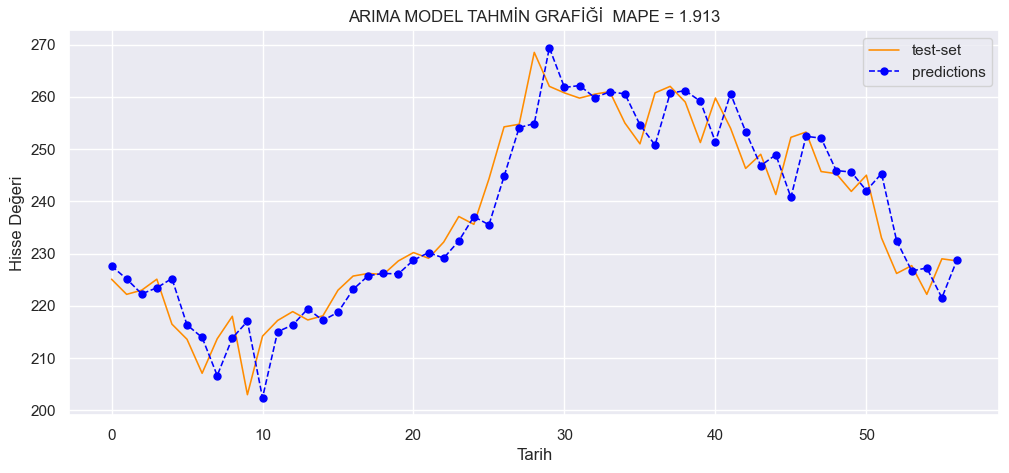

In [109]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(thyao_arima_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("ARIMA MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(thyao_arima_mape,3)))
plt.legend();

# SARIMA MODEL
## SARIMA MODEL PARAMETRE OPTİMİZASYONU

In [76]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)
# Best SARIMA(0, 1, 0)x(0, 1, 1, 5)12 - AIC:3080.159322901155 <- parametreler.

SARIMA(0, 1, 0)x(0, 1, 1, 5)12 - AIC:3080.1593209118164


### ONE STEP AHEAD METHOD

In [77]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
thyao_sarima_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model = SARIMAX(final_train, order=best_order, seasonal_order=best_seasonal_order)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    thyao_sarima_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value);

### SARIMA MODEL HATASI


In [78]:
thyao_sarima_rmse = np.sqrt(mean_squared_error(test,thyao_sarima_model_predictions)) # RMSE = 5.940884071283915
test = np.array(test)
thyao_sarima_model_predictions = np.array(thyao_sarima_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
thyao_sarima_mape = mape(test,thyao_sarima_model_predictions) 
print(thyao_sarima_mape)# MAPE = 1.9197340451530074

1.9197340451530074


### SARIMA MODEL TAHMİN GRAFİĞİ

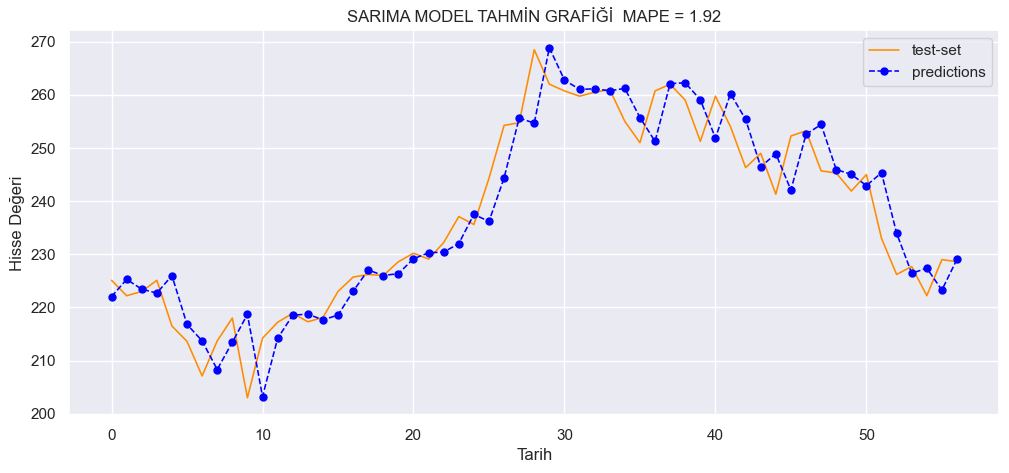

In [79]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(thyao_sarima_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("SARIMA MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(thyao_sarima_mape,3)))
plt.legend();

# ANN MODEL(LSTM)

In [80]:
#data = yf.download("THYAO.IS", start="2021-01-01", end="2024-01-01")
#prices = data['Close'].values  # Assuming 'Close' column has stock prices

In [81]:
data = pd.read_csv("THYAO.IS.csv")
prices = data['Close'].values

### Veri Ölçeklendirme

In [82]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

### ONE STEP AHEAD METHOD DATA CREATION

In [83]:
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)
lookback = 30

### Veri Bölümlemesi

In [84]:
train_size = int(len(prices_scaled) * 0.925) 
train_data = prices_scaled[:train_size]
test_data = prices_scaled[train_size - lookback:]  
train_size, len(train_data), len(test_data)

(693, 693, 87)

In [85]:
# Ayrı ayrı veri seti oluştur
X_train, y_train = create_dataset(train_data, lookback)
X_test, y_test = create_dataset(test_data, lookback)
# LSTM için giriş verisini yeniden şekillendir
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [86]:
# Model oluştur
tf.random.set_seed(42)
model = Sequential([
    LSTM(50, activation='relu', input_shape=(lookback, 1)),
    Dense(1)])
# Modeli derle
model.compile(optimizer='adam', loss='mse')
# Modeli eğit
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1010 - val_loss: 0.0039
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2711e-04 - val_loss: 0.0022
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3256e-04 - val_loss: 0.0021
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6919e-04 - val_loss: 0.0021
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7644e-04 - val_loss: 0.0020
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7178e-04 - val_loss: 0.0019
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6946e-04 - val_loss: 0.0019
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6473e-04 - val_loss: 0.0018
Epoch 10/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5945e-04 - val_loss: 0.0017
Epoch 11/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5316e-04 - val_loss: 0.0017
Epoch 12/20
42/42 ━━━━━━━━━━━━━━━━━━━━

### ANN MODEL HATASI

In [87]:
thyao_ann_pred = model.predict(X_test)
# Veriyi orijinal ölçeğe geri çevir
y_pred_ann_inverse = scaler.inverse_transform(thyao_ann_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
def mape(actual, predictions):
    return np.mean(np.abs((actual - predictions) / actual)) * 100
thyao_ann_mape = mape(y_test_inverse, y_pred_ann_inverse)
print(thyao_ann_mape) # MAPE = 3.4906190200886043

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3.300156576390783


In [88]:
test = np.array(y_test_inverse)
thyao_ann_model_predictions = np.array(y_pred_ann_inverse)

### ANN MODEL TAHMİN GRAFİĞİ

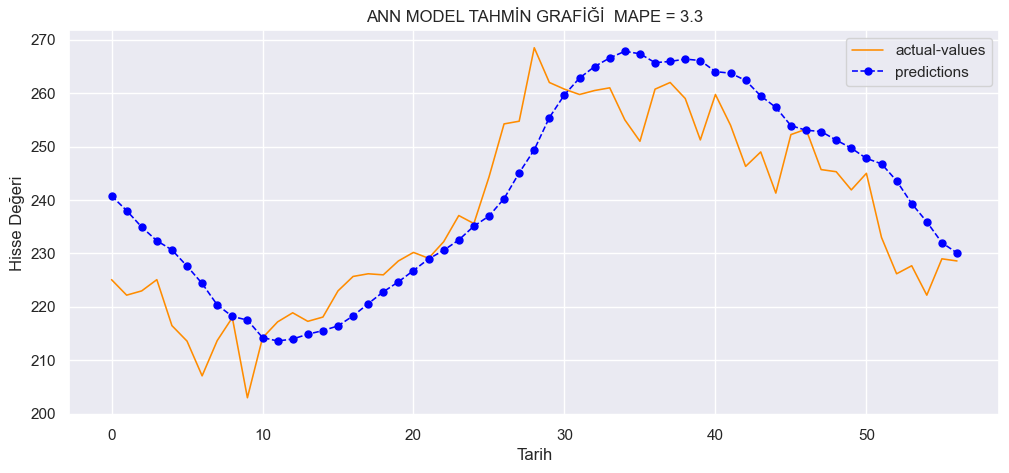

In [89]:
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(thyao_ann_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("ANN MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(thyao_ann_mape,3)))
plt.legend();

# CNN MODEL

In [90]:
from tensorflow.keras.layers import Conv1D, Dense, Flatten
#data = yf.download("THYAO.IS", start="2021-01-01", end="2024-01-01")
#prices = data['Close'].values  

In [91]:
data = pd.read_csv("THYAO.IS.csv")
prices = data["Close"].values

In [92]:
# Parametreler
lookback = 10
test_size = 57
# Veriyi böl (lookback'i unutma!)
train_prices = prices[:-(test_size)]
test_prices = prices[-(test_size + lookback):]  # Test için lookback öncesi veriler dahil edilir
# Ölçeklendirme (sadece train'e fit et)
scaler = MinMaxScaler(feature_range=(0, 1))
train_prices_scaled = scaler.fit_transform(train_prices.reshape(-1, 1))
test_prices_scaled = scaler.transform(test_prices.reshape(-1, 1))

In [93]:
# Dataset oluşturma fonksiyonu
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)
X_train, y_train = create_dataset(train_prices_scaled, lookback)
X_test, y_test = create_dataset(test_prices_scaled, lookback)

In [94]:
# CNN için reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [95]:
# Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(lookback, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
# Compile
model.compile(optimizer='adam', loss='mse')
# Eğitim
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test));

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0650 - val_loss: 0.0037
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 6.9269e-04 - val_loss: 0.0023
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 6.4092e-04 - val_loss: 0.0021
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 6.1976e-04 - val_loss: 0.0020
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 6.0708e-04 - val_loss: 0.0019
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 5.9709e-04 - val_loss: 0.0018
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 5.8704e-04 - val_loss: 0.0018
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 5.7777e-04 - val_loss: 0.0017
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 5.6963e-04 - val_loss: 0.0016
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 5.6273e-04 - val_loss: 0.0016
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 5.5697e-04 - val_loss: 0.0015
Epoch 12/20
43

### CNN MODEL HATASI

In [96]:
y_pred_scaled = model.predict(X_test)
thyao_cnn_y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100
thyao_cnn_mape = mape(y_test_inverse, thyao_cnn_y_pred)
print(f"Test MAPE: {thyao_cnn_mape}") # Test MAPE: 2.8667282543144212

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test MAPE: 2.8832145571348318


### CNN MODEL TAHMİN GRAFİĞİ:

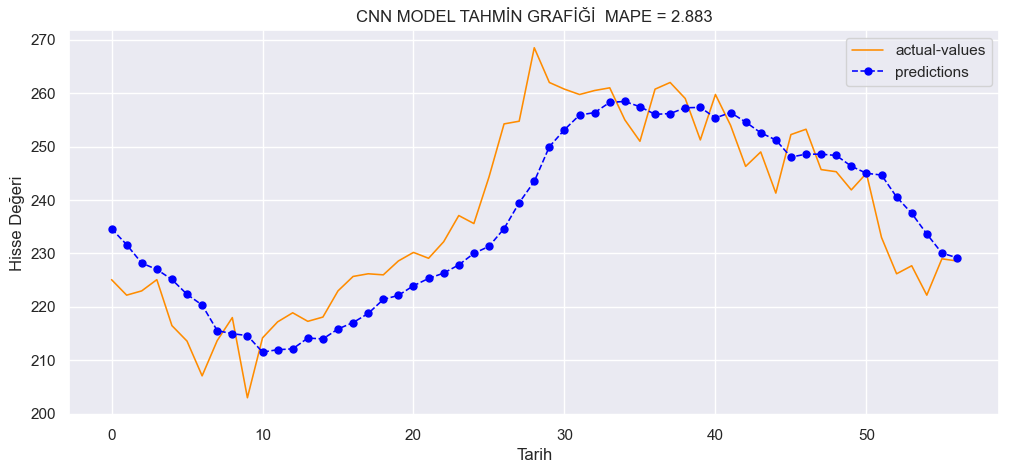

In [97]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(thyao_cnn_y_pred,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("CNN MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(thyao_cnn_mape,3)))
plt.legend();

### KOMBİNASYON YÖNTEMİ VE BAŞARISI

## YÖNTEMLERİN MAPE DEĞERLERİ:

In [110]:
best_model = pd.DataFrame([thyao_ses_mape, thyao_des_mape, thyao_tes_mape,
                           thyao_arima_mape, thyao_sarima_mape,
                           thyao_ann_mape, thyao_cnn_mape],

                          index=["SES MODEL", "DES MODEL", "TES MODEL", "ARIMA MODEL", "SARIMA MODEL","ANN MODEL","CNN MODEL"],

                          columns=["MAPE Değerleri"])
print(best_model.sort_values("MAPE Değerleri", ascending=True));

              MAPE Değerleri
ARIMA MODEL         1.912538
SARIMA MODEL        1.919734
SES MODEL           1.999246
CNN MODEL           2.883215
TES MODEL           3.273450
ANN MODEL           3.300157
DES MODEL          12.393517


**EN DÜŞÜK MAPE DEĞERİNE SAHİP 3 YÖNTEMİN ORTALAMASINI ALALIM**

In [111]:
predictions = np.stack([thyao_arima_model_predictions.flatten(), thyao_sarima_model_predictions.flatten(),thyao_ses_model_predictions.flatten()], axis=1)

# Bu tahminlerin ortalaması:
average_predictions = np.mean(predictions, axis=1)

print(average_predictions)

[224.04329253 224.81628231 222.88641407 223.0446597  225.15413586
 217.58472484 214.55218847 208.54498973 213.25662366 217.17469161
 204.58879304 213.66134508 216.63483721 218.50480779 217.39372919
 218.37373146 222.35953192 225.535451   225.81138168 226.05892968
 228.44839727 229.85515897 229.5544757  231.79241801 236.40889378
 235.63802605 243.26753936 252.85643453 253.97530919 266.76816559
 262.19710411 261.48183013 260.44779045 260.72029048 260.85231012
 255.90026754 251.84491594 260.2243627  261.26975349 259.25556468
 252.59962879 259.50217516 254.72825783 247.75312513 249.07311479
 242.45858732 251.39391035 252.70952157 246.63417204 245.68310697
 242.8936972  245.0418387  234.67959001 227.95618647 227.84633999
 223.2320572  228.40348196]


**KOMBİNE EDİLEN TAHMİNLERİN MAPE DEĞERİ**

In [112]:
from sklearn.metrics import mean_absolute_percentage_error
combined_mape = mean_absolute_percentage_error(test,average_predictions)*100
print(combined_mape) #  MAPE = 1.891056433721091

1.8910564337210924


#

In [116]:
best_model = pd.DataFrame([thyao_arima_mape, thyao_sarima_mape,
                        thyao_ses_mape,combined_mape],

                          index=["ARIMA MODEL", "SARIMA MODEL","SES MODEL","COMBINED PREDICTION"],

                          columns=["THYAO MAPE Değerleri"])
print(best_model.sort_values("THYAO MAPE Değerleri", ascending=True));

                     THYAO MAPE Değerleri
COMBINED PREDICTION              1.891056
ARIMA MODEL                      1.912538
SARIMA MODEL                     1.919734
SES MODEL                        1.999246


In [115]:
combined_RMSE = np.sqrt(mean_squared_error(test,average_predictions)) # RMSE = 1.5401875579197315
print(combined_RMSE);

5.793305331997246


In [117]:
best_model_RMSE = pd.DataFrame([thyao_arima_rmse, thyao_sarima_rmse,
                           thyao_ses_rmse, combined_RMSE],

                          index=["ARIMA MODEL", "SARIMA MODEL","SES MODEL","COMBINED PREDICTION"],

                          columns=["THYAO RMSE Değerleri"])
print(best_model_RMSE.sort_values("THYAO RMSE Değerleri", ascending=True));

                     THYAO RMSE Değerleri
COMBINED PREDICTION              5.793305
ARIMA MODEL                      5.864505
SARIMA MODEL                     5.940884
SES MODEL                        5.985589


**YÖNTEMLERİN MAPE DEĞERLERİ BİRBİRİNE ÇOK YAKIN GELMİŞTİR. KOMBİNASYON İLE ELDE EDİLEN TAHMİNLERİN MAPE DEĞERİ 2. SIRADA YER ALMIŞTIR!**

## KOMBİNE TAHMİNLERİN GRAFİĞİ:

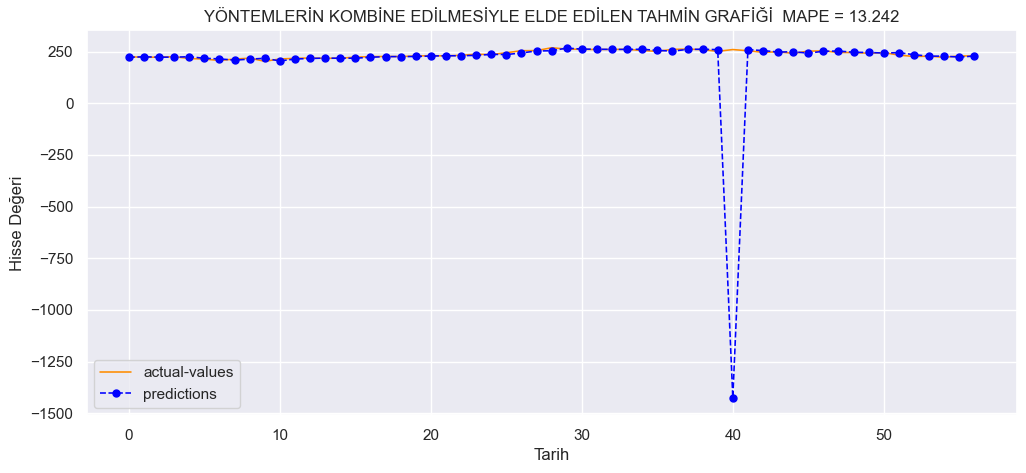

In [102]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(average_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("YÖNTEMLERİN KOMBİNE EDİLMESİYLE ELDE EDİLEN TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(combined_mape,3)))
plt.legend();

#

**En düşük MAPE değerine sahip yöntemlerin kombine edilmesiyle elde edilen tahminler yüzdelik olarak en düşük hatayı veren tahminler olmuştur!**